In [1]:
import sys
import os

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
# sys_model = Systems.NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)
sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [6]:
TRAIN_SEQ_LEN = 10
VALID_SEQ_LEN = 10  # Změněno z 20
TEST_SEQ_LEN = 250   # Změněno z 200

# Počty trajektorií
NUM_TRAIN_TRAJ = 300 # Změněno z 500
NUM_VALID_TRAJ = 5   # Změněno z 250
NUM_TEST_TRAJ = 10  # Změněno z 100

# Batch size
BATCH_SIZE = 5         # Zůstává stejné


x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
ekf = Filters.ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']
P_hat_ekf = ekf_results['P_filtered']

In [ ]:
state_knet = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10, num_gru_layers=1).to(device)
trained_model = utils.train_bkn_with_empirical_averaging(
    state_knet, train_loader, val_loader, device, 
    total_train_iter=1500,
    lr=1e-3,
    clip_grad=10,
    J_samples=30,
    final_beta=0.1,        # Začneme s rozumnou hodnotou pro `mean` v L2
    reg_weight=1,
    validation_period=100,
    logging_period=25,
)


--- Iterace [0/1500] ---
--- Loss Stats ---
  Total Loss:       0.839345 | Current Beta: 0.0000
    ├─ L1 (MSE):   0.764656 (váha: 1.00)
    ├─ L2 (Var L1):33.911613 (váha: 0.0000)
    └─ Regularize: 0.074688 (váha: 1)
--- Variance Stats ---
  Predicted Var -> Avg: 0.011449, Min: 0.000023, Max: 0.077033
  True Var      -> Avg: 0.764656, Min: 0.000288, Max: 2.896924
--- Mean (State) Stats ---
  Predicted Mean-> Avg: 0.600953, Min: -0.454795, Max: 1.109281
  True Mean     -> Avg: 0.230151, Min: -0.820343, Max: 1.529237
--- Gradient Stats ---
  Layer: dnn.input_layer.0.weight       | Grad norm: 0.076933
  Layer: dnn.input_layer.0.bias         | Grad norm: 0.088937
  Layer: dnn.concrete_dropout1.p_logit  | Grad norm: 0.047167
  Layer: dnn.gru.weight_ih_l0           | Grad norm: 0.239011
  Layer: dnn.gru.weight_hh_l0           | Grad norm: 0.039500
  Layer: dnn.gru.bias_ih_l0             | Grad norm: 0.065908
  Layer: dnn.gru.bias_hh_l0             | Grad norm: 0.044798
  Layer: dnn.output

KeyboardInterrupt: 

In [12]:
import torch
import torch.nn.functional as F
import numpy as np

# ==============================================================================
# Předpoklady:
# Následující proměnné a moduly musí být definovány a naimportovány PŘED 
# spuštěním tohoto skriptu:
#
# import utils                  # Váš modul pro generování dat
# import Filters                 # Váš modul obsahující EKF
# from StateBayesianKalmanNet import StateBayesianKalmanNet # Vaše třída modelu
#
# device = torch.device(...)   # Např. torch.device("cuda" if torch.cuda.is_available() else "cpu")
# state_knet = ...             # Instance vaší natrénované třídy StateBayesianKalmanNet
# sys_true = ...               # Instance třídy popisující skutečný systém
# sys_model = ...              # Instance třídy popisující model systému (pro EKF)
# ==============================================================================


# --- 1. Definice pomocných funkcí a metrik ---

def calculate_anees(x_true_list, x_hat_list, P_hat_list):
    """
    Vypočítá Average NEES (ANEES) ze seznamů trajektorií.
    """
    num_runs = len(x_true_list)
    if num_runs == 0:
        return 0.0
        
    total_nees = 0.0
    for i in range(num_runs):
        x_true = x_true_list[i]
        x_hat = x_hat_list[i]
        P_hat = P_hat_list[i]
        
        seq_len = x_true.shape[0]
        state_dim = x_true.shape[1]
        nees_samples_run = torch.zeros(seq_len)

        for t in range(seq_len):
            error = x_true[t] - x_hat[t]
            P_t = P_hat[t]
            
            P_t_matrix = P_t.reshape(state_dim, state_dim)
                
            P_stable = P_t_matrix + torch.eye(state_dim, device=P_t_matrix.device) * 1e-9
            
            try:
                P_inv = torch.inverse(P_stable)
                nees_samples_run[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
            except torch.linalg.LinAlgError:
                nees_samples_run[t] = float('nan')
            
        total_nees += torch.nanmean(nees_samples_run).item()
        
    return total_nees / num_runs

# --- 2. Příprava a generování dat ---

TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 10
J_SAMPLES_TEST = 20

print(f"Generuji {NUM_TEST_TRAJ} testovacích trajektorií...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

# --- 3. Vyhodnocovací smyčka ---

state_knet.eval()

all_x_true_cpu, all_x_hat_knet_cpu, all_P_hat_knet_cpu = [], [], []
all_x_hat_ekf_cpu, all_P_hat_ekf_cpu = [], []

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        # Data pro jednu trajektorii, zůstávají na CPU
        y_test_seq_cpu = y_test[i]
        x_true_seq_cpu = x_test[i]
        
        all_x_true_cpu.append(x_true_seq_cpu)
        
        # --- Vyhodnocení vaší StateBayesianKalmanNet ---
        
        # Přesun dat na GPU těsně před použitím
        y_test_seq_gpu = y_test_seq_cpu.to(device)
        x_true_seq_gpu = x_true_seq_cpu.to(device)
        
        initial_state_gpu = x_true_seq_gpu[0, :].unsqueeze(0)
        state_knet.reset(batch_size=1, num_samples=J_SAMPLES_TEST, initial_state=initial_state_gpu)
        
        knet_predictions_gpu = []
        knet_covariances_gpu = []
        
        for t in range(1, TEST_SEQ_LEN):
            y_t_gpu = y_test_seq_gpu[t, :].unsqueeze(0)
            x_ensemble_t, _ = state_knet.step(y_t_gpu, num_samples=J_SAMPLES_TEST)
            x_filtered_t = x_ensemble_t.mean(dim=0)
            diff = x_ensemble_t - x_filtered_t
            P_filtered_t = (diff.unsqueeze(-1) * diff.unsqueeze(-2)).mean(dim=0)
            knet_predictions_gpu.append(x_filtered_t)
            knet_covariances_gpu.append(P_filtered_t)
            
        x_hat_knet_seq_gpu = torch.cat(knet_predictions_gpu, dim=0)
        P_hat_knet_seq_gpu = torch.cat(knet_covariances_gpu, dim=0)
        
        x_hat_knet_full = torch.cat([initial_state_gpu, x_hat_knet_seq_gpu], dim=0)
        P0_knet_gpu = torch.eye(state_knet.state_dim, device=device).unsqueeze(0) * 1e-6
        P_hat_knet_full = torch.cat([P0_knet_gpu, P_hat_knet_seq_gpu], dim=0)
        
        all_x_hat_knet_cpu.append(x_hat_knet_full.cpu())
        all_P_hat_knet_cpu.append(P_hat_knet_full.cpu())
        
        # --- Vyhodnocení ExtendedKalmanFilter ---
        ekf_instance = Filters.ExtendedKalmanFilter(sys_model)
        
        # Nastavíme počáteční stav a kovarianci
        ekf_instance.Ex0 = x_true_seq_cpu[0, :].unsqueeze(-1).to(ekf_instance.device)
        ekf_instance.P0 = torch.eye(sys_model.state_dim, device=ekf_instance.device) * 1e-6
        
        # EKF filtruje celou sekvenci měření (interně si nastaví počáteční stav z Ex0)
        y_test_seq_for_ekf = y_test_seq_cpu.to(ekf_instance.device)
        ekf_results = ekf_instance.apply_filter(y_test_seq_for_ekf)
        
        x_hat_ekf_cpu = ekf_results['x_filtered'].cpu()
        P_hat_ekf_cpu = ekf_results['P_filtered'].cpu()

        all_x_hat_ekf_cpu.append(x_hat_ekf_cpu)
        all_P_hat_ekf_cpu.append(P_hat_ekf_cpu)
        
        if (i + 1) % 1 == 0:
            print(f"Dokončeno {i + 1}/{NUM_TEST_TRAJ} běhů...")

# --- 4. Finální výpočet průměrných metrik ---
x_true_all = torch.cat(all_x_true_cpu)
x_hat_knet_all = torch.cat(all_x_hat_knet_cpu)
x_hat_ekf_all = torch.cat(all_x_hat_ekf_cpu)

avg_mse_knet = F.mse_loss(x_hat_knet_all, x_true_all).item()
avg_mse_ekf = F.mse_loss(x_hat_ekf_all, x_true_all).item()

anees_knet = calculate_anees(all_x_true_cpu, all_x_hat_knet_cpu, all_P_hat_knet_cpu)
anees_ekf = calculate_anees(all_x_true_cpu, all_x_hat_ekf_cpu, all_P_hat_ekf_cpu)


# --- 5. Finální výpis ---
# Definujeme `state_dim_for_nees` bezpečně
state_dim_for_nees = all_x_true_cpu[0].shape[1]

print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)
print("\n--- Průměrná MSE (přesnost) ---")
print(f"EKF:              {avg_mse_ekf:.4f}")
print(f"Bayesian KNet:    {avg_mse_knet:.4f}")
print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim_for_nees:.4f}")
print("---------------------------------------")
print(f"EKF:              {anees_ekf:.4f}")
print(f"Bayesian KNet:    {anees_knet:.4f}")
print("="*50)

Generuji 10 testovacích trajektorií...
Vyhodnocuji na 10 testovacích trajektoriích...
Dokončeno 1/10 běhů...
Dokončeno 2/10 běhů...
Dokončeno 3/10 běhů...
Dokončeno 4/10 běhů...
Dokončeno 5/10 běhů...
Dokončeno 6/10 běhů...
Dokončeno 7/10 běhů...
Dokončeno 8/10 běhů...
Dokončeno 9/10 běhů...
Dokončeno 10/10 běhů...

FINÁLNÍ VÝSLEDKY (průměr přes 10 běhů)

--- Průměrná MSE (přesnost) ---
EKF:              0.1304
Bayesian KNet:    0.1340

--- Průměrný ANEES (kredibilita/kalibrace) ---
Očekávaná hodnota: 1.0000
---------------------------------------
EKF:              0.9937
Bayesian KNet:    2742.8016


Připravuji data pro online simulaci...
Zahajuji simulaci online filtrace...
Online simulace dokončena.

--- Výsledky online simulace ---
  Celková MSE: 0.1527
  Průměrný NEES: 587.4460
  Průměrný čas na jeden krok filtrace: 17.5942 ms


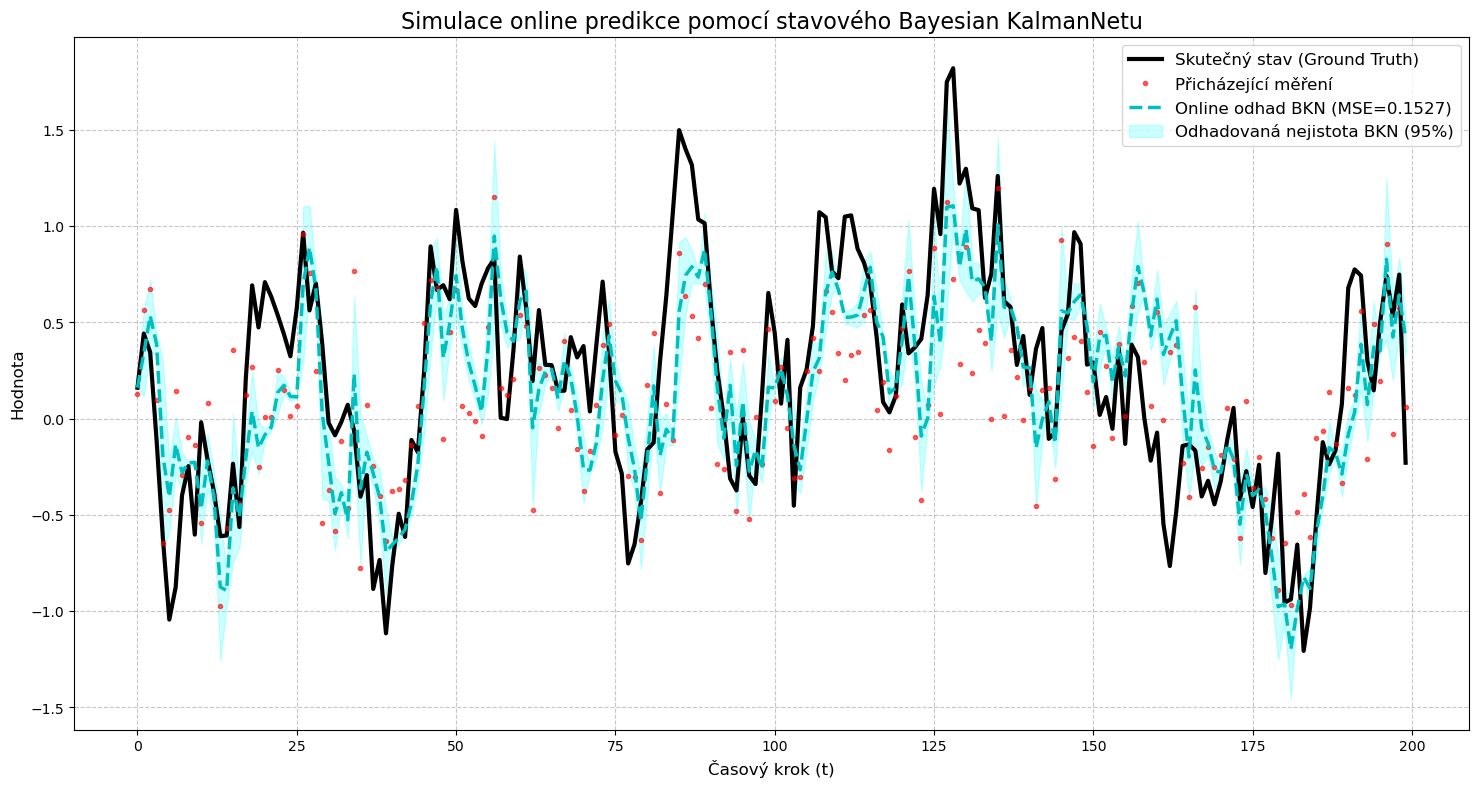

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np

# ==============================================================================
# Předpoklady:
# Následující proměnné a moduly musí být definovány a naimportovány PŘED 
# spuštěním tohoto skriptu:
#
# import utils
# from StateBayesianKalmanNet import StateBayesianKalmanNet
#
# device = torch.device(...)
# state_knet = ... (instance vaší natrénované třídy)
# sys_true = ...
# ==============================================================================


# --- 1. Definice pomocných funkcí a metrik ---

def calculate_nees(x_true, x_hat, P_hat):
    """
    Vypočítá Normalized Estimation Error Squared (NEES) pro jednu trajektorii.
    """
    seq_len = x_true.shape[0]
    state_dim = x_true.shape[1]
    nees_samples = torch.zeros(seq_len)

    for t in range(seq_len):
        error = x_true[t] - x_hat[t]
        P_t = P_hat[t]
            
        P_t_matrix = P_t.reshape(state_dim, state_dim)
        P_stable = P_t_matrix + torch.eye(state_dim, device=P_t_matrix.device) * 1e-9
        
        try:
            P_inv = torch.inverse(P_stable)
            nees_samples[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        except torch.linalg.LinAlgError:
            nees_samples[t] = float('nan')
            
    avg_nees = torch.nanmean(nees_samples).item()
    return avg_nees

# --- 2. Příprava ---

TEST_SEQ_LEN = 200
J_SAMPLES_TEST = 20

print("Připravuji data pro online simulaci...")
x_online_test, y_online_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

y_online_seq_gpu = y_online_test.squeeze(0).to(device)
x_true_seq_cpu = x_online_test.squeeze(0).cpu()

# --- 3. Simulace online filtrace ---

print("Zahajuji simulaci online filtrace...")

state_knet.eval()

# Počáteční stav pro oba filtry
initial_state_gpu = x_true_seq_cpu[0, :].unsqueeze(0).to(device)
state_knet.reset(batch_size=1, num_samples=J_SAMPLES_TEST, initial_state=initial_state_gpu)

online_predictions = []
online_covariances = []
step_times = []

with torch.no_grad():
    for t in range(1, TEST_SEQ_LEN): # Začínáme od 1, protože t=0 je daný
        
        start_time = time.time()
        
        y_t_gpu = y_online_seq_gpu[t, :].unsqueeze(0)
        
        # --- ZMĚNA ZDE ---
        # 1. Získáme celý ansámbl odhadů z `.step()` metody
        x_ensemble_t, _ = state_knet.step(y_t_gpu, num_samples=J_SAMPLES_TEST)
        
        # 2. Vypočítáme průměr (odhad stavu) a kovarianční matici
        x_filtered_t = x_ensemble_t.mean(dim=0)
        diff = x_ensemble_t - x_filtered_t
        P_filtered_t = (diff.unsqueeze(-1) * diff.unsqueeze(-2)).mean(dim=0)
        
        end_time = time.time()
        step_times.append(end_time - start_time)
        
        online_predictions.append(x_filtered_t.cpu())
        online_covariances.append(P_filtered_t.cpu())

print("Online simulace dokončena.")

# --- 4. Zpracování a vyhodnocení výsledků ---

# Spojíme výsledky a odstraníme přebytečnou `batch_size=1` dimenzi
x_hat_online_seq = torch.cat(online_predictions, dim=0)
P_hat_online_seq = torch.cat(online_covariances, dim=0)

# Přidáme počáteční stav, aby se srovnávaly stejně dlouhé sekvence
x_hat_online = torch.cat([x_true_seq_cpu[0:1], x_hat_online_seq], dim=0)
P0_online = torch.eye(state_knet.state_dim).unsqueeze(0) * 1e-6
P_hat_online = torch.cat([P0_online, P_hat_online_seq], dim=0)

mse_online = F.mse_loss(x_hat_online, x_true_seq_cpu)
avg_step_time_ms = np.mean(step_times) * 1000

nees_online = calculate_nees(x_true_seq_cpu, x_hat_online, P_hat_online)

print("\n--- Výsledky online simulace ---")
print(f"  Celková MSE: {mse_online.item():.4f}")
print(f"  Průměrný NEES: {nees_online:.4f}")
print(f"  Průměrný čas na jeden krok filtrace: {avg_step_time_ms:.4f} ms")


# --- 5. Vizualizace ---

plt.figure(figsize=(18, 9))
plt.title("Simulace online predikce pomocí stavového Bayesian KalmanNetu", fontsize=16)

# Extrakce dat pro plotování
x_true_plot = x_true_seq_cpu.numpy().squeeze()
y_meas_plot = y_online_seq_gpu.cpu().numpy().squeeze() # Přesunuto z GPU pro plot
bkn_mean = x_hat_online.numpy().squeeze()
bkn_std = torch.sqrt(torch.diagonal(P_hat_online, dim1=-2, dim2=-1)).numpy().squeeze()
time_steps = range(len(x_true_plot))

plt.plot(time_steps, x_true_plot, 'k-', linewidth=3, label="Skutečný stav (Ground Truth)")
plt.plot(time_steps, y_meas_plot, 'r.', markersize=6, alpha=0.6, label="Přicházející měření")
plt.plot(time_steps, bkn_mean, 'c--', linewidth=2.5, label=f"Online odhad BKN (MSE={mse_online.item():.4f})")
plt.fill_between(time_steps, bkn_mean - 2 * bkn_std, bkn_mean + 2 * bkn_std, 
                 color='cyan', alpha=0.2, label='Odhadovaná nejistota BKN (95%)')

plt.xlabel("Časový krok (t)", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()